Set up library imports

In [89]:
import requests, re, json, praw, pprint, time
import pandas as pd
import numpy as np
from psaw import PushshiftAPI    # PSAW recommended by following PRAW errors
import datetime as dt            # PSAW docs
from IPython.display import display
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

In [5]:
# Initializing reddit API

reddit = praw.Reddit(client_id='CmKUgfSklwH6Gw',
                     client_secret='WprZwImA7V8TcggsN0GfpZOfl2g',
                     user_agent='ClassProjectBot-PRAW/PSAW',
                     password='dsBaLpQSua2ctCXU2XyupJ',
                     username='refused_dev')

# Set PushShiftAPI
api = PushshiftAPI()

# Set a variable equal to the target subreddit
r_all = reddit.subreddit('all')

In [ ]:
# Grab submissions from the subreddit
subs = []
for sub in r_all.hot(limit=None):
    sub_dict = {}
    sub_dict['submissions'] = sub
    subs.append(sub_dict)
subscrape = pd.DataFrame(subs)
subscrape.shape, subscrape.head()

# Save submission pull to csv
subscrape.to_csv("subs.csv")

In [ ]:
# Grab features from the submission IDs
sublist = []
for c in subscrape['submissions']:
    subdict = {}
    subdict['title'] = c.title
    subdict['comments'] = c.num_comments
    subdict['crossposts'] = c.num_crossposts
    subdict['score'] = c.score
    subdict['subreddit'] = c.subreddit
    subdict['domain'] = c.domain
    subdict['gilded'] = c.gilded
    subdict['upvote_ratio'] = c.upvote_ratio
    subdict['created'] = c.created
    fri_sublist.append(subdict)

df = pd.DataFrame(sublist)

def get_date(created):
    return dt.datetime.fromtimestamp(created)

stamp = data['created'].apply(get_date)
data = data.assign(timestamp = stamp)
data.drop(columns='created', inplace=True)
data.to_csv('9068df_with_time.csv')

Load up previous scrapes

In [6]:
df = pd.read_csv('df_w_feats.csv')
display(df.shape, df.head().sort_values('score', ascending=False))

(22767, 10)

,Unnamed: 0,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio
2,2,3232,1.527744e+09,4,youtube.com,5,83372,videos,Gamer bet if the new Bethesda reveal was not F...,0.78
3,3,2439,1.527740e+09,6,smh.com.au,0,61556,worldnews,"Police faked 258,000 breath tests in shocking ...",0.89
0,0,268,1.527746e+09,1,i.redd.it,0,54696,BikiniBottomTwitter,About to make a splash? More like just about t...,0.82
1,1,3771,1.527740e+09,2,thehill.com,0,39344,politics,FBI is reconstructing shredded documents obtai...,0.89
4,4,275,1.527748e+09,0,i.redd.it,0,31701,PrequelMemes,"Always 2 there are, no more, no less",0.85


In [7]:
# df.drop(columns='Unnamed: 0', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22767 entries, 0 to 22766
Data columns (total 10 columns):
Unnamed: 0      22767 non-null int64
comments        22767 non-null int64
created         22767 non-null float64
crossposts      22767 non-null int64
domain          22767 non-null object
gilded          22767 non-null int64
score           22767 non-null int64
subreddit       22767 non-null object
title           22767 non-null object
upvote_ratio    22767 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.7+ MB


In [8]:
# convert unix timecode to human readable

def get_date(created):
    return dt.datetime.fromtimestamp(created)
stamp = df['created'].apply(get_date)
df = df.assign(timestamp = stamp)

In [9]:
display(df.shape,df.head())

(22767, 11)

,Unnamed: 0,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp
0,0,268,1.527746e+09,1,i.redd.it,0,54696,BikiniBottomTwitter,About to make a splash? More like just about t...,0.82,2018-05-31 01:59:13
1,1,3771,1.527740e+09,2,thehill.com,0,39344,politics,FBI is reconstructing shredded documents obtai...,0.89,2018-05-31 00:20:29
2,2,3232,1.527744e+09,4,youtube.com,5,83372,videos,Gamer bet if the new Bethesda reveal was not F...,0.78,2018-05-31 01:14:48
3,3,2439,1.527740e+09,6,smh.com.au,0,61556,worldnews,"Police faked 258,000 breath tests in shocking ...",0.89,2018-05-31 00:14:09
4,4,275,1.527748e+09,0,i.redd.it,0,31701,PrequelMemes,"Always 2 there are, no more, no less",0.85,2018-05-31 02:31:16


In [35]:
# df['datetime'] = df.timestamp.values.astype('datetime64[D]')

In [10]:
# calculate percentiles

p25, p50, p75 = np.percentile(df.comments, 25), np.percentile(df.comments, 50), np.percentile(df.comments, 75)
print(p25, p50, p75)

df['p25'] = df['comments'] <= p25
df['p50'] = df['comments'] <= p50
df['p75'] = df['comments'] <= p75

# posts with over the median amount of comments are a success
# dft['success'] = dft['p50'].map({False : 1, True : 0})
df['over25p'] = df['p25'].map({False : 1, True : 0})
df['over50p'] = df['p50'].map({False : 1, True : 0}) # median
df['over75p'] = df['p75'].map({False : 1, True : 0})

11.0 31.0 86.0


In [11]:
y = df['over50p']
# y.tolist()

# y = pd.DataFrame(y)
y.shape

(22767,)

## Subreddit Analysis

In [14]:
trainx, testx, trainy, testy = train_test_split(df, y, test_size=.20,
                                                    random_state=19)

In [15]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((18213, 17), (18213,), (4554, 17), (4554,))

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


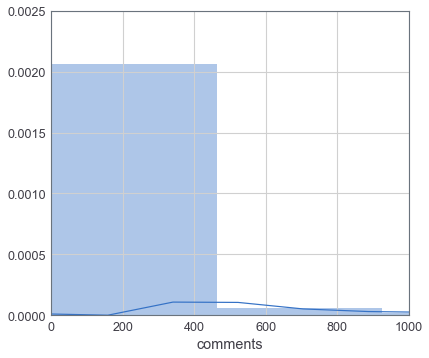

In [96]:
jtplot.style()
# setting axis range in seaborn:
# sns.distplot(dft.comments, kde=True).set(xlim=(0, 1000), ylim=(0, 0.0025));



In [39]:
cvec = CountVectorizer()
trainx_counts = cvec.fit_transform(trainx.subreddit)
xtrainbag = pd.DataFrame(trainx_counts.todense(), 
                         columns=cvec.get_feature_names())
xtrainbag.sum(axis=0).sort_values(ascending=False).head()

# make a word cloud here!

the_donald      639
politics        358
ice_poseidon    336
dankmemes       222
me_irl          197
dtype: int64

In [17]:
# pipeline to evaluate subreddits vs success

pipe = make_pipeline(CountVectorizer(),
                    RandomForestClassifier())
pipe.fit(trainx['subreddit'], trainy)
pipe.score(testx['subreddit'], testy)

0.7222222222222222

In [43]:
pred = pipe.predict(testx['subreddit'])
print(classification_report(pred, testy))

             precision    recall  f1-score   support

          0       0.75      0.71      0.73      2419
          1       0.69      0.73      0.71      2135

avg / total       0.72      0.72      0.72      4554



In [82]:
importantfeats = pd.DataFrame(pipe.steps[1][1].feature_importances_,
                              pipe.steps[0][1].get_feature_names())

In [86]:
importantfeats.sort_values(0,ascending=False).head()

,0
the_donald,0.014045
nba,0.012254
soccer,0.008974
fortnitebr,0.007712
askreddit,0.006033


In [64]:
subrpipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("rf", RandomForestClassifier(random_state=19, n_jobs=2))])


params = {
}

gs_subr = GridSearchCV(subrpipe, params, cv=5).fit(trainx['subreddit'],trainy)
print("Score:", gs_subr.score(testx['subreddit'],testy))


print("Cross Validation Results: \n\n", 
      gs_subr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_subr.best_score_, '\n\n',
     "Best parameters:",
     gs_subr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_subr.best_estimator_,'\n\n',)

Score: 0.7206851119894598


In [87]:
subrlogit = subrpipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("lr", LogisticRegression(random_state=19, n_jobs=2))])
params = {}
gs_lr = GridSearchCV(subrpipe, params, cv=5).fit(trainx['subreddit'],trainy)
print("Score:", gs_lr.score(testx['subreddit'],testy))


print("Cross Validation Results: \n\n", 
      gs_lr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_lr.best_score_, '\n\n',
     "Best parameters:",
     gs_lr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_lr.best_estimator_,'\n\n',)

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/saqibnizami/anaconda3

Score: 0.7250768555116381
Cross Validation Results: 

 {'mean_fit_time': array([0.11523995]), 'std_fit_time': array([0.05312905]), 'mean_score_time': array([0.0150342]), 'std_score_time': array([0.00156849]), 'params': [{}], 'split0_test_score': array([0.72934395]), 'split1_test_score': array([0.713423]), 'split2_test_score': array([0.72879495]), 'split3_test_score': array([0.71252059]), 'split4_test_score': array([0.71801208]), 'mean_test_score': array([0.72041948]), 'std_test_score': array([0.00730676]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.78826356]), 'split1_train_score': array([0.79231297]), 'split2_train_score': array([0.79073439]), 'split3_train_score': array([0.79246448]), 'split4_train_score': array([0.79136641]), 'mean_train_score': array([0.79102836]), 'std_train_score': array([0.00152036])} 

 Best score: 

 0.7204194805907868 

 Best parameters: {} 

 Best estimator:

 Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


### Vectorize titles and add them to the model.

In [92]:
# FROM SKLEARN DOCS
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
featunion = FeatureUnion(
    transformer_list=[('titles', Pipeline([('selector', ItemSelector(key='title')), 
                                           ('tfidf', TfidfVectorizer(min_df=50))])),
                      ('comments', PI)])
bigpipe = Pipeline([
    # FeatureUnion to process columns of dataframe accordingly
    ('union', FeatureUnion(
        transformers=[
            # Vectorize titles
            ('titles', Pipeline([
                ('selector', ItemSelector(key'title')),
                
            ]))
            
        ]))
])

In [ ]:
# pipeline stuff
# use a randomforest
tfvect = TfidfVectorizer(stop_words='english')
rf = RandomForestClassifier()
logreg = LogisticRegression()

tube = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = 'english')),
    ('rf', RandomForestClassifier()),
    ('lr', LogisticRegression())
    sd
])

params = {
    'tfidf__min_df': ,
    'tfidf_max_df': ,
    'rf__max_depth': ,
    'rf__min_samples_',
    'lr__penalty':['l1','l2'],
    'lr__'
}

gs = GridSearchCV(tube, param_grid=params)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

In [88]:
nonword=list(X_train.columns)
del(nonword[0])



nonword_pipeline = Pipeline([
    ('selector', Selector(key=nonword)),
    ('ss', StandardScaler())
])



word_pipeline = Pipeline([
    ('selector', Selector(key='title')),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])



merge = FeatureUnion([
    ('word', word_pipeline),
    ('nonword', nonword_pipeline)
])


main_pipeline = Pipeline([
    ('merger',merge),
    ('logreg', LogisticRegression()),
])

main_pipeline.fit(X_train, y_train)

NameError: name 'Selector' is not defined

In [90]:
trainx.head()

,Unnamed: 0,comments,created,crossposts,domain,gilded,score,subreddit,title,upvote_ratio,timestamp,p25,p50,p75,over25p,over50p,over75p
19058,19058,278,1.527837e+09,1,i.redd.it,0,7240,FortNiteBR,LTM Idea: Prop Hunt,0.91,2018-06-01 03:11:12,False,False,False,1,1,1
15420,15420,46,1.527903e+09,0,i.redd.it,0,654,ShitPostCrusaders,Rate my prom tie.,0.98,2018-06-01 21:30:53,False,False,True,1,1,0
22607,22607,103,1.527876e+09,0,i.redd.it,0,2047,PropagandaPosters,"""Indie Must Be Free! Work and Fight for it!"", ...",0.98,2018-06-01 13:52:05,False,False,False,1,1,1
20418,20418,15,1.527902e+09,0,imgur.com,0,49,Ice_Poseidon,Found mugshot of Brandon's brother Robert Grosso,0.83,2018-06-01 21:06:48,False,True,True,1,0,0
10071,10071,57,1.527769e+09,0,v.redd.it,0,314,rupaulsdragrace,throwback to aquaria's most ICONIC (and nude) ...,0.96,2018-05-31 08:16:34,False,False,True,1,1,0


In [96]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

In [101]:
# make pipelines for each column
# comments = Pipeline([
#     ('select', ItemSelector(key='comments'),
#     ('std', StandardScaler()))
# ])
# score = Pipeline([
#     ('select', ItemSelector(key='score'),
#     ('std', StandardScaler()))
# ])
# upvote = Pipeline([
#     ('select', ItemSelector(key='upvote_ratio'),
#     ('std', StandardScaler()))
# ])
domain = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
subreddit = Pipeline([
    ('select', ItemSelector(key='subreddit')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
title = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])

# FeatureUnion-ize the column pipes
colpipes = FeatureUnion([("domain", domain),
                         ("subreddit", subreddit),
                         ("title", title)])
# master pipes
pipe_rf = Pipeline([
    ('colpipes',colpipes),
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_rf.fit(trainx, trainy)
print("Score RFC: ", pipe_rf.score(testx, testy))

pipe_lr = Pipeline([
    ('colpipes',colpipes),
    ('clf', LogisticRegression(random_state=42))
])
pipe_lr.fit(trainx, trainy)
print("Score LogReg: ", pipe_lr.score(testx, testy))



Score RFC:  0.7033377250768555
Score LogReg:  0.7206851119894598


In [111]:
pipe_rf.named_steps['clf'].classes_

array([0, 1])

In [124]:
headers = ["name", "score"]
values = sorted(zip(trainx.columns, pipe_rf.named_steps['clf'].feature_importances_), key=lambda x: x[1] * -1)
featimp = pd.DataFrame(values, columns=['feature', 'score'])
featimp

,feature,score
0,upvote_ratio,1.800621e-04
1,gilded,9.459197e-05
2,over75p,6.045332e-05
3,p50,5.789609e-05
4,crossposts,5.360407e-05
5,over50p,5.085026e-05
6,p75,4.665586e-05
7,domain,3.603651e-05
8,title,3.358909e-05
9,comments,3.198984e-07


In [99]:
gs = GridSearchCV()

Pipeline(memory=None,
     steps=[('colpipes', FeatureUnion(n_jobs=1,
       transformer_list=[('domain', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='domain')), ('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='conten...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [95]:
ItemSelector(trainx, key='comments')

TypeError: __init__() got multiple values for argument 'key'